In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
if (!require("stringr")) install.packages("stringr")
library('stringr')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
supermarket <- read_csv('supermarket_sales.csv')
    names(supermarket) <- str_replace_all(names(supermarket), " ", "_")

supermarket_sales <- supermarket%>%
    mutate(Customer_type = as_factor(Customer_type), Gender = as.numeric(as_factor(Gender)))
supermarket_sales%>%
    slice(1:5)

Parsed with column specification:
cols(
  `Invoice ID` = col_character(),
  Branch = col_character(),
  City = col_character(),
  `Customer type` = col_character(),
  Gender = col_character(),
  `Product line` = col_character(),
  `Unit price` = col_double(),
  Quantity = col_double(),
  `Tax 5%` = col_double(),
  Total = col_double(),
  Date = col_character(),
  Time = col_time(format = ""),
  Payment = col_character(),
  cogs = col_double(),
  `gross margin percentage` = col_double(),
  `gross income` = col_double(),
  Rating = col_double()
)



Invoice_ID,Branch,City,Customer_type,Gender,Product_line,Unit_price,Quantity,Tax_5%,Total,Date,Time,Payment,cogs,gross_margin_percentage,gross_income,Rating
<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<time>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
750-67-8428,A,Yangon,Member,1,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
226-31-3081,C,Naypyitaw,Normal,1,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00,Cash,76.40,4.761905,3.8200,9.6
631-41-3108,A,Yangon,Normal,2,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23:00,Credit card,324.31,4.761905,16.2155,7.4
123-19-1176,A,Yangon,Member,2,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
373-73-7910,A,Yangon,Normal,2,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3


In [5]:
set.seed(1)
supermarket_split <- initial_split(supermarket_sales, prop = 0.70, strata = Customer_type) 
supermarket_train <- training(supermarket_split)
supermarket_test <- testing(supermarket_split)

supermarket_train%>%
    slice(1:5)

Invoice_ID,Branch,City,Customer_type,Gender,Product_line,Unit_price,Quantity,Tax_5%,Total,Date,Time,Payment,cogs,gross_margin_percentage,gross_income,Rating
<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<time>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
226-31-3081,C,Naypyitaw,Normal,1,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00,Cash,76.40,4.761905,3.8200,9.6
631-41-3108,A,Yangon,Normal,2,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23:00,Credit card,324.31,4.761905,16.2155,7.4
123-19-1176,A,Yangon,Member,2,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
373-73-7910,A,Yangon,Normal,2,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3
699-14-3026,C,Naypyitaw,Normal,2,Electronic accessories,85.39,7,29.8865,627.6165,3/25/2019,18:30:00,Ewallet,597.73,4.761905,29.8865,4.1


In [6]:
supermarket_recipe <- recipe(Customer_type ~ Gender + Total + Rating , data = supermarket_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
supermarket_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [24]:
supermarket_vfold <- vfold_cv(supermarket_train, v = 5, strata = Customer_type)


In [25]:
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [26]:
supermarket_workflow <- workflow()%>%
     add_recipe(supermarket_recipe) %>%
     add_model(knn_spec) %>%
     tune_grid(resamples = supermarket_vfold, grid = 10)%>%
     collect_metrics()
supermarket_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4836170,5,0.01342595,Model1
1,roc_auc,binary,0.4835815,5,0.01343627,Model1
3,accuracy,binary,0.4579230,5,0.01049130,Model2
3,roc_auc,binary,0.4437861,5,0.01341181,Model2
5,accuracy,binary,0.4593009,5,0.01046001,Model3
5,roc_auc,binary,0.4381739,5,0.01458778,Model3
7,accuracy,binary,0.4521581,5,0.01875668,Model4
7,roc_auc,binary,0.4356939,5,0.02062695,Model4
9,accuracy,binary,0.4379534,5,0.01818947,Model5


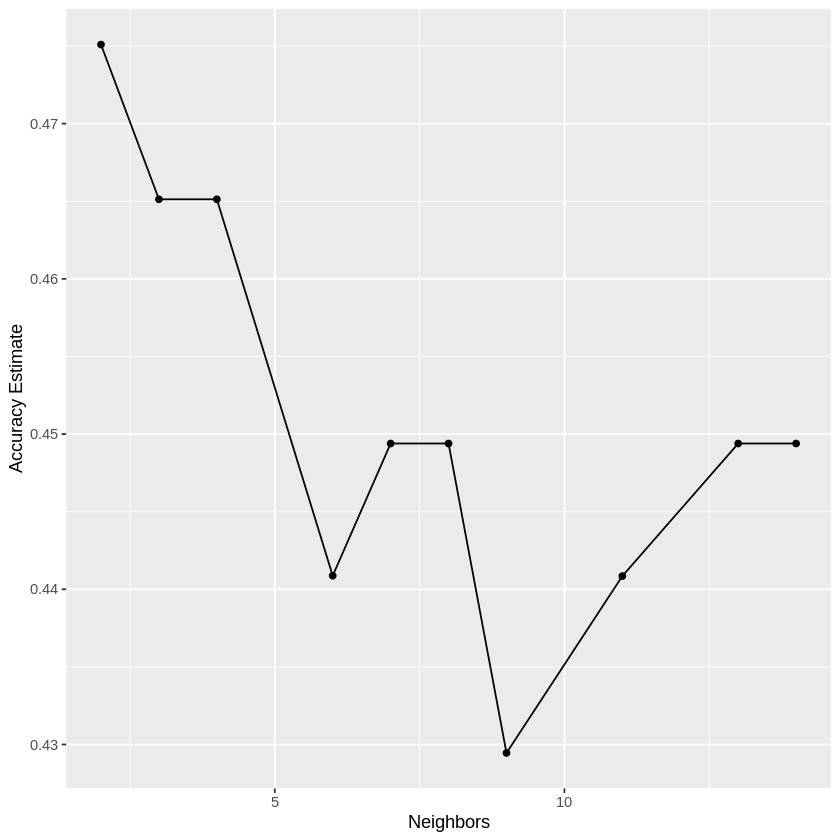

In [27]:
supermarket_accuracies <- supermarket_workflow%>%
    filter(.metric == 'accuracy')
 
cross_val_plot <- ggplot(supermarket_accuracies, aes(x = neighbors, y = mean)) +
    geom_point()+
    geom_line()+
    labs(x = 'Neighbors', y = 'Accuracy Estimate')

cross_val_plot

